# Stats

In [1]:
import ast
import csv
import os
import pickle
import re
from collections import defaultdict
from collections import Counter
from datetime import datetime
from datetime import timedelta
from string import punctuation

import matplotlib
import numpy as np
import networkx as nx
import pandas as pd
import requests
import seaborn as sns
from geolocation.main import GoogleMaps
from matplotlib import pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON

from googlemaps_key import KEY

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

## Préstamos

### Localizados

In [3]:
%%time

localizados_df = pd.read_csv('autores5.csv', header=0)
localizados_df = localizados_df.fillna('')

CPU times: user 6.04 s, sys: 282 ms, total: 6.33 s
Wall time: 6.32 s


In [4]:
localizados_df.shape

(3054360, 6)

### Latinoamericanos

In [5]:
%%time

latinoamericanos_df = pd.read_csv(
    'autores_iberoamericanos.csv',
    header=0,
    converters={
        'GEOLOC_CAPITAL_AUTOR': ast.literal_eval,
        'GEOLOC_CAPITAL_EJEMPLAR': ast.literal_eval,
        'GEOLOC_CIUDAD_AUTOR': ast.literal_eval
    }
)
latinoamericanos_df = latinoamericanos_df.fillna('')

CPU times: user 510 ms, sys: 4.05 ms, total: 514 ms
Wall time: 512 ms


In [6]:
latinoamericanos_df.shape

(13782, 10)

### Colombianos

In [7]:
%%time

colombianos_df = pd.read_csv(
    'autores_colombianos_3.csv',
    header=0,
    converters={
        'GEOLOC_CAPITAL_AUTOR': ast.literal_eval,
        'GEOLOC_CAPITAL_EJEMPLAR': ast.literal_eval,
        'GEOLOC_CIUDAD_AUTOR': ast.literal_eval
    }
)
colombianos_df = colombianos_df.fillna('')

CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 167 ms


In [8]:
colombianos_df.shape

(3217, 13)

## Resultados

### 1. Todos

In [9]:
prestamos_totales_df = localizados_df

#### a) Número de préstamos

In [10]:
len(prestamos_totales_df)

3054360

#### b) Número de títulos

In [11]:
prestamos_totales_df.TITULO.nunique()

319830

#### c) Número de autores

In [12]:
prestamos_totales_df.AUTOR.nunique()

144515

### 2. Localizados

In [13]:
prestamos_localizados_df = prestamos_totales_df[prestamos_totales_df.NOMBRE_LOCALIZADO != 'DESCONOCIDO']

#### a) Número de préstamos

In [14]:
len(prestamos_localizados_df)

808101

#### b) Número de títulos

In [15]:
prestamos_localizados_df.TITULO.nunique()

55908

#### c) Número de autores

In [16]:
prestamos_localizados_df.NOMBRE_LOCALIZADO.nunique()

11874

### 3. Latinoamericanos

In [17]:
autores_latinoamericanos = latinoamericanos_df.NOMBRE_LOCALIZADO.unique()
prestamos_latinoamericanos_df = \
    prestamos_localizados_df[prestamos_localizados_df.NOMBRE_LOCALIZADO.isin(autores_latinoamericanos)]

#### a) Número de préstamos

In [18]:
len(prestamos_latinoamericanos_df)

174255

#### b) Número de títulos

In [19]:
prestamos_latinoamericanos_df.TITULO.nunique()

12201

#### c) Número de autores

In [20]:
prestamos_latinoamericanos_df.NOMBRE_LOCALIZADO.nunique()

1802

### 4. Colombianos

In [21]:
autores_colombianos = colombianos_df.NOMBRE_LOCALIZADO.unique()
prestamos_colombianos_df = \
    prestamos_latinoamericanos_df[prestamos_latinoamericanos_df.NOMBRE_LOCALIZADO.isin(autores_colombianos)]

#### a) Número de préstamos

In [22]:
len(prestamos_colombianos_df)

68113

#### b) Número de títulos

In [23]:
prestamos_colombianos_df.TITULO.nunique()

2646

#### c) Número de autores

In [24]:
prestamos_colombianos_df.NOMBRE_LOCALIZADO.nunique()

180

## Visualizaciones

In [25]:
indice1 = ['Préstamos', 'Títulos', 'Autores']

In [26]:
todos_sr = pd.Series([
        len(prestamos_totales_df),
        prestamos_totales_df.TITULO.nunique(),
        prestamos_totales_df.AUTOR.nunique()
    ], index=indice1,
)

In [27]:
localizados_sr = pd.Series([
        len(prestamos_localizados_df),
        prestamos_localizados_df.TITULO.nunique(),
        prestamos_localizados_df.NOMBRE_LOCALIZADO.nunique()
    ], index=indice1,
)

In [28]:
latinoamericanos_sr = pd.Series([
        len(prestamos_latinoamericanos_df),
        prestamos_latinoamericanos_df.TITULO.nunique(),
        prestamos_latinoamericanos_df.NOMBRE_LOCALIZADO.nunique()
    ], index=indice1,
)

In [29]:
colombianos_sr = pd.Series([
        len(prestamos_colombianos_df),
        prestamos_colombianos_df.TITULO.nunique(),
        prestamos_colombianos_df.NOMBRE_LOCALIZADO.nunique()
    ], index=indice1,
)

In [30]:
df = pd.DataFrame({
        'todos': todos_sr,
        'localizados': localizados_sr,
        'latinoamericanos': latinoamericanos_sr,
        'colombianos': colombianos_sr,
    })

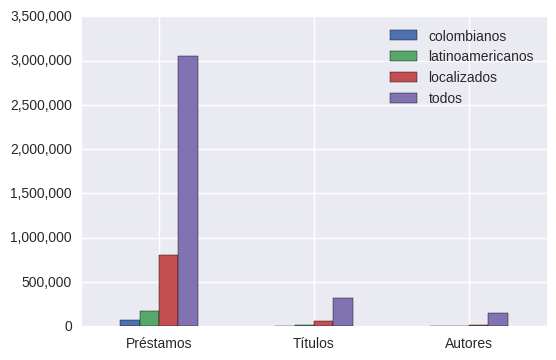

In [31]:
ax = df.plot(kind='bar', rot='0')
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)

In [32]:
indice2 = ['Todos', 'Localizados', 'Latinoamericanos', 'Colombianos']

In [33]:
prestamos_sr = pd.Series([
        len(prestamos_totales_df),
        len(prestamos_localizados_df),
        len(prestamos_latinoamericanos_df),
        len(prestamos_colombianos_df),
    ], index=indice2,
)

In [34]:
titulos_sr = pd.Series([
        prestamos_totales_df.TITULO.nunique(),
        prestamos_localizados_df.TITULO.nunique(),
        prestamos_latinoamericanos_df.TITULO.nunique(),
        prestamos_colombianos_df.TITULO.nunique(),
    ], index=indice2,
)

In [35]:
autores_sr = pd.Series([
        prestamos_totales_df.AUTOR.nunique(),
        prestamos_localizados_df.NOMBRE_LOCALIZADO.nunique(),
        prestamos_latinoamericanos_df.NOMBRE_LOCALIZADO.nunique(),
        prestamos_colombianos_df.NOMBRE_LOCALIZADO.nunique(),
    ], index=indice2,
)

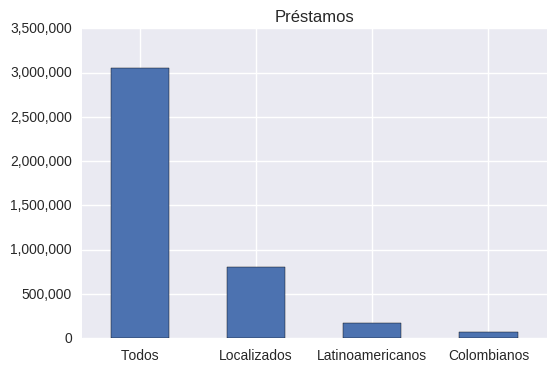

In [36]:
ax = prestamos_sr.plot(kind='bar', rot='0', title='Préstamos')
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)

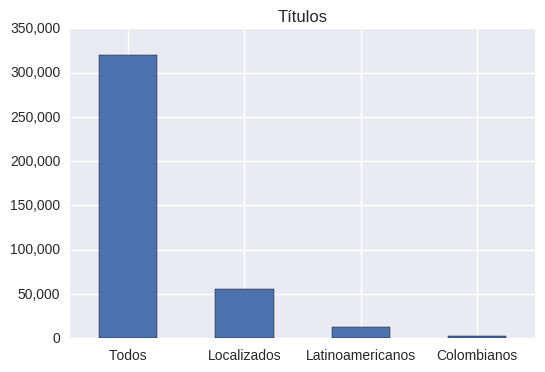

In [37]:
ax = titulos_sr.plot(kind='bar', rot='0', title='Títulos')
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)

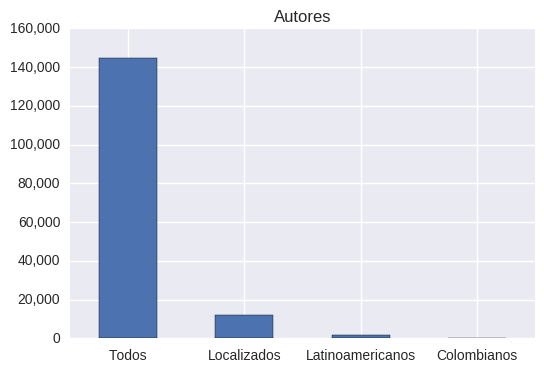

In [38]:
ax = autores_sr.plot(kind='bar', rot='0', title='Autores')
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)